In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.container { 
    width: 100% !important;
}
</style>
"""))

In [4]:
import torch
from torch import nn, Tensor
from model.fuzzy_layer import FuzzyUnsignedConjunction, FuzzyUnsignedDisjunction, FuzzyNumKeepup, keepidx, fuzzy_dropup
from model.fuzzy_logic import ProductLogic, MinimumLogic, LukasiewiczLogic, DrasticLogic, SchweizerSklarLogic
from model.fuzzy_layer import FuzzyParam, FuzzyLoss
from model.bool_logic import BoolLogic
from cache import TrainingRegime, TestMetric
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from util import shuffle


In [19]:
class MNISTAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 16),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 28*28),
            nn.LeakyReLU(),
        )
        
    def encode(self, input):
        return self.encoder(input)
    
    def decode(self, latent):
        decoded = self.decoder(latent)
        return decoded.reshape(*decoded.shape[:-1], 1, 28, 28)
    
    def forward(self, input):
        return self.decode(self.encode(input))

In [20]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

trainset = datasets.MNIST(root='./_mnist', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./_mnist', train=False, download=True, transform=transforms.ToTensor())

trainloader = DataLoader(trainset, batch_size=128)
testloader = DataLoader(testset, batch_size=128)

In [39]:
def train_loop(model, optim, loader, epochs):
    losses = []
    for epoch_no in range(1, epochs + 1):
        for imgs, _ in tqdm(loader, desc="Training Epoch %s" % epoch_no, leave=False):
            decoding = model(imgs.cuda())
            loss = ((imgs.cuda() - decoding) ** 2).sum()
            losses.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()
    return torch.tensor(losses)

In [41]:
model = MNISTAutoEncoder().cuda()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loop(model, optim, trainloader, epochs=15)

Training Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

tensor([10414.3525, 10415.4238,  9835.7441,  ...,  1831.5569,  1625.9136,
         1425.3306])

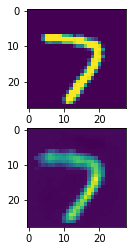

In [49]:
for imgs, _ in testloader:
    i=17
    img = imgs[i:i+1]
    decoding = model(img.cuda())
    fig, ax = plt.subplots(2)
    ax[0].imshow(img.squeeze().cpu().numpy())
    ax[1].imshow(decoding.squeeze().detach().cpu().numpy())
    break